# Micromagnetic standard problem 4

**Author**: Marijan Beg

**Date**: 26 Feb 2016

### Problem specification

The simulated sample is a thin film cuboid with dimesions:
- length $L = 500 \,\text{nm}$,
- width $d = 125 \,\text{nm}$, and
- thickness $t = 3 \,\text{nm}$.

The material parameters (similar to permalloy) are:

- exchange energy constant $A = 1.3 \times 10^{-11} \,\text{J/m}$,
- magnetisation saturation $M_\text{s} = 8 \times 10^{5} \,\text{A/m}$.

Magnetisation dynamics is governed by the Landau-Lifshitz-Gilbert equation

$$\frac{d\mathbf{m}}{dt} = -\gamma_{0}(\mathbf{m} \times \mathbf{H}_\text{eff}) + \alpha\left(\mathbf{m} \times \frac{d\mathbf{m}}{dt}\right)$$

where $\gamma_{0} = 2.211 \times 10^{5} \,\text{m}\,\text{A}^{-1}\,\text{s}^{-1}$ is the gyromagnetic ratio and $\alpha=0.02$ is the Gilbert damping.

In the standard problem 4, the system is firstly relaxed at zero external magnetic field and then, stating from the obtained equlibrium configuration, the magnetisation dynamics is simulated for two different external magnetic fields separately:

1. $\mathbf{H}_{1} = (-24.6, 4.3, 0.0) \,\text{mT}$
2. $\mathbf{H}_{2} = (-35.5, -6.3, 0.0) \,\text{mT}$

The micromagnetic standard problem 4 specification can be also found in Ref. 1.

### Simulation

In [2]:
from fidimag.micro import Sim
from fidimag.common import CuboidMesh
from fidimag.micro import UniformExchange, Demag, Zeeman

Firtsly, a mesh for the simulated geometry with discretisation $d_{x}=d_{y} = 2.5 \,\text{nm}$ and $d_{z} = 3 \,\text{nm}$ is created

In [3]:
# Mesh dimensions.
L = 500  # nm
d = 125  # nm
t = 3  # nm

# Mesh discretisation.
dx = 2.5  # nm
dy = 2.5  # nm
dz = 3  # nm

# Create a mesh.
mesh = CuboidMesh(nx=int(L/dx), ny=int(d/dy), nz=int(t/dz), dx=dx, dy=dy, dz=dz, unit_length=1e-9)

Now, the simulation object is created, parameters set, energies added, and magnetisation configuration initialised:

In [4]:
Ms = 8e5  # magnetisation saturation (A/m)
A = 1.3e-11  # exchange energy constant (J/m)
alpha = 0.02  # Gilbert damping
gamma = 2.211e5  # gyromagnetic ration (m/As)

# Create simulation object.
sim = Sim(mesh)

# Set simulation parameters.
sim.Ms = Ms
sim.alpha = alpha
sim.gamma = gamma

# Add energies.
sim.add(UniformExchange(A=A))
sim.add(Demag())

# Since the magnetisation dynamics is not important in this stage,
# the precession term in LLG equation can be set to artificially zero.
sim.do_procession = False

# Initialise the system.
sim.set_m((1, 0.25, 0.1))

Finally, the system can be relaxed and the obtained equilibrium configuration saved, so that it can be used as an initial state for simulating magnetisation dynamics when two different external magnetic fields are applied.

In [5]:
# Relax the system to its equilibrium.
sim.relax(dt=1e-13, stopping_dmdt=0.01, max_steps=5000, save_m_steps=None, save_vtk_steps=None)

# Save the equilibrium configuration.
import numpy as np
np.save("m0.npy", sim.spin)

step=1, time=1e-13, max_dmdt=28.359 ode_step=0
step=2, time=2e-13, max_dmdt=28.3274 ode_step=7.21303e-14
step=3, time=3e-13, max_dmdt=28.2939 ode_step=7.21303e-14
step=4, time=4.53293e-13, max_dmdt=28.2508 ode_step=1.53293e-13
step=5, time=7.39211e-13, max_dmdt=28.1764 ode_step=2.85917e-13
step=6, time=1.22705e-12, max_dmdt=28.0475 ode_step=4.87835e-13
step=7, time=1.71488e-12, max_dmdt=27.8873 ode_step=4.87835e-13
step=8, time=2.20271e-12, max_dmdt=27.7305 ode_step=4.87835e-13
step=9, time=3.02147e-12, max_dmdt=27.5258 ode_step=8.18751e-13
step=10, time=3.84022e-12, max_dmdt=27.2763 ode_step=8.18751e-13
step=11, time=4.65897e-12, max_dmdt=27.0353 ode_step=8.18751e-13
step=12, time=5.47772e-12, max_dmdt=26.8026 ode_step=8.18751e-13
step=13, time=7.05825e-12, max_dmdt=26.4757 ode_step=1.58053e-12
step=14, time=8.63879e-12, max_dmdt=26.0672 ode_step=1.58053e-12
step=15, time=1.02193e-11, max_dmdt=25.6825 ode_step=1.58053e-12
step=16, time=1.17999e-11, max_dmdt=25.3193 ode_step=1.58053e-1

Now, when the equilibrium configuration is obtained, the magnetisation evolution can be simulated for two different external magnetic fields using the following function:

In [7]:
def field_simulation(mesh, H):

    sim = Sim(mesh)

    sim.set_tols(rtol=1e-8, atol=1e-8)
    sim.alpha = alpha
    sim.gamma = gamma
    sim.Ms = Ms

    sim.add(UniformExchange(A))
    sim.add(Demag())
    sim.add(Zeeman(H))
            
    sim.set_m(np.load('m0.npy'))
    
    T = 1e-9  # s
    n_steps = 201
    t_array = np.linspace(0, T, n_steps)
    
    mav_x = []
    mav_y = []
    mav_z = []
    for t in t_array:
        sim.run_until(t)
        mav = sim.compute_average()
        mav_x.append(mav[0])
        mav_y.append(mav[1])
        mav_z.append(mav[2])
        
    return t_array, mav_x, mav_y, mav_z

Using the created field_simulation function, we obtain the average magnetisation components time evolutions.

In [11]:
mu0 = 4*np.pi*1e-7  # magnetic constant (H/m)
H1 = np.array([-24.6, 4.3, 0.0])*1e-3/mu0
H2 = np.array([-35.5, -6.3, 0.0])*1e-3/mu0

t1, mx1, my1, mz1 = field_simulation(mesh, H1)
t2, mx2, my2, mz2 = field_simulation(mesh, H2)

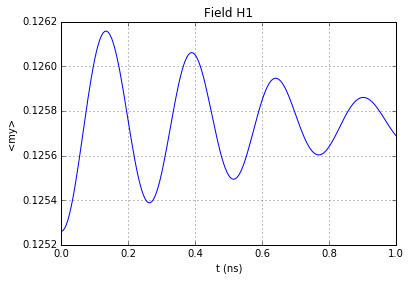

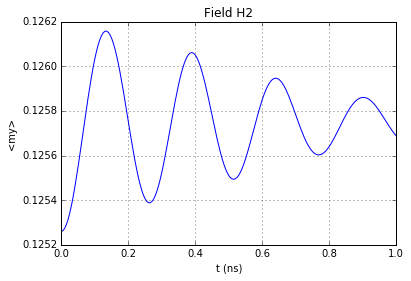

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(t1/1e-9, my1)
plt.grid()
plt.xlabel('t (ns)')
plt.ylabel('<my>')
plt.title('Field H1')
plt.show()

plt.plot(t2/1e-9, my2)
plt.grid()
plt.xlabel('t (ns)')
plt.ylabel('<my>')
plt.title('Field H2')
plt.show()

### References

[1] muMAG Micromagnetics Website. URL: http://www.ctcms.nist.gov/~rdm/mumag.org.html (Date of access: 26/02/2016)